<a href="https://colab.research.google.com/github/songqsh/foo1/blob/master/src/q_learning_dirichlet_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Goal__

Here we solve 1d Dirichlet problem with q_learning. The same example with value iteration is given [here](https://github.com/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d_v01.ipynb).

__Conclusion__

- Q_learning is kind of Monte carlo and much more instable than value iteration in 1-d problem.
But it may work for high dimensional problem while value iteration may not. 

- Another observation is the quality of the solution highly depends on the initial q_table. In particular, one can feed initial q_value with the exact solution of continuous time problem, if it is available.

In [0]:
import numpy as np
import time
start_time = time.time()

from tqdm import tqdm
import matplotlib.pyplot as plt

In [0]:
#PDE to be solved
class pde:
  def __init__(self):
    #pde config
    self.name = 'HJB 1d'
    
    self.U_LIM = 1 #upper limit for state
    self.L_LIM = 0 #lower limit for state

    self.lambda_ = 0. #discount rate
    self.sigma = 1. #diffusion coefficient
    self.drift = lambda x,a: a #drift coefficient function

    self.run_cost = lambda x, a: (a**2+1)/2.

    C1 = 1; C2 = 1
    self.term_cost = lambda x: - np.log(C1*np.exp(x) + C2*np.exp(-x))
    
    #pde exact solution if available
    self.exact_sol = self.term_cost

In [0]:
def mdp_space_config(self, 
                     NUM = 5 #num of meshes in one unit state space
                    ):
  self.NUM = NUM
  
  self.h = 1./self.NUM #mesh size in state space

  self.s_space = np.arange(self.L_LIM, self.U_LIM+self.h, self.h) #state space

  self.a_space = np.arange(2*self.L_LIM, 2*self.U_LIM + self.h, self.h) #action space

  self.del_ind_space = np.array([-1,1]) #space of delta (1-step) index: -1 means left, 1 means right move

  self.term_ind_space = np.array([0, self.s_space.size-1]) #space of terminal state indice

  #q-table and state value initialization

  self.s_val = np.zeros(self.s_space.size)
  self.q_table = np.zeros([self.s_space.size, self.a_space.size])
  
  '''
  #for test purpose, adjust initialization as exact solution
  self.s_val = self.exact_sol(self.s_space)
  for i in range(self.s_space.size):
    self.q_table[i] = self.s_val[i]*np.ones(self.a_space.size)
  '''
  
  print('>>>>> q_table size is %i' %(self.q_table.size))

  #s_val and q-table terminal setup
  for i in self.term_ind_space:
    self.s_val[i] = self.term_cost(self.s_space[i])
    for j in range(self.a_space.size):
      self.q_table[i,j] = self.term_cost(self.s_space[i])
  
  
pde.mdp_space_config = mdp_space_config

In [0]:
#transition probability
#output is probability (np array) on del_ind_space 
#central fdm

def mdp_trans_prob_central(self,x,a):
  tp = np.zeros(self.del_ind_space.shape)
  
  b_ = self.drift(x,a)
  tp[0] = (-b_*self.h + self.sigma**2)/(2*self.sigma**2)
  tp[1] = (b_*self.h + self.sigma**2)/(2*self.sigma**2)
  
  #correction on prob
  if tp[1]<0:
    tp = tp - tp[1]
    tp = tp/tp.sum()
    print('>>>>corrected probability due to negativity')

  return tp  

pde.mdp_trans_prob_central = mdp_trans_prob_central

In [0]:
def q_learning(self, n_epoch = 50000, learning_rate = 0.001, start_state = 0.5):
  start_ind = np.int((start_state - self.L_LIM)/self.h)
  Lambda_ = 1 + self.lambda_* self.h**2/ self.sigma**2 # reciprocal of discount factor
  for epoch in tqdm(range(n_epoch)):
    now_ind_ = start_ind #start
    
    while now_ind_ not in self.term_ind_space:
      act_ind_ = np.argmin(self.q_table[now_ind_]) #choose action index
      
      x_ = self.s_space[now_ind_] #current state
      a_ = self.a_space[act_ind_] #current action
      
      run_cost_ = self.run_cost(x_,a_)*self.h**2/self.sigma**2 #compute running cost
      tp_ = self.mdp_trans_prob_central(x_, a_) #transition probability
      
      sampling_ = np.random.binomial(1, tp_[0]) #random sampling 
      del_ind_ = 1 # to the right
      if sampling_ == 0:
        del_ind_ = -1 #to the left
      next_ind_ = now_ind_ + del_ind_ #next state index
      
      del_q = run_cost_ + self.s_val[next_ind_]/Lambda_ - self.q_table[now_ind_,act_ind_] #delta of q value for update
      self.q_table[now_ind_, act_ind_] += learning_rate*del_q #update q_value
      self.s_val[now_ind_] = np.min(self.q_table[now_ind_]) #sync q_table with s_val
      
      now_ind_ = next_ind_
  return self.s_val[start_ind]
  
pde.q_learning = q_learning
  

In [6]:
ans = 0
n = 5
for i in range(n):
  pde1 = pde()
  pde1.mdp_space_config(NUM=8)
  ans += pde1.q_learning()
  
print('\n soln is'+str(ans/n))

  1%|          | 276/50000 [00:00<00:18, 2752.57it/s]

>>>>> q_table size is 153


  1%|          | 291/50000 [00:00<00:17, 2900.64it/s]

>>>>> q_table size is 153


  1%|          | 304/50000 [00:00<00:16, 3031.76it/s]

>>>>> q_table size is 153


  1%|          | 321/50000 [00:00<00:15, 3203.49it/s]

>>>>> q_table size is 153


  1%|          | 291/50000 [00:00<00:17, 2897.84it/s]

>>>>> q_table size is 153


100%|██████████| 50000/50000 [00:17<00:00, 2853.22it/s]


 soln is-0.7572697808225146


In [7]:
end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 87.380742 seconds


In [8]:
pde1.exact_sol(0.5)

-0.8132616875182228

In [9]:
pde1.s_val

array([-0.69314718, -0.68978342, -0.70290325, -0.73102253, -0.77703311,
       -0.84228545, -0.92013197, -1.01565081, -1.12692801])

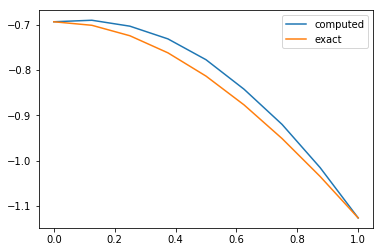

In [10]:
plt.plot(pde1.s_space, pde1.s_val, label = 'computed')

exact_val = pde1.exact_sol(pde1.s_space)
plt.plot(pde1.s_space, exact_val, label = 'exact')
plt.legend()

